## Description 

In this notebook, we look at enrollment data for the State of Tennessee.

In [94]:
import glob 
import csv
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [95]:
merged_csvs = glob.glob('../raw_data_files_clean/merged_*')
merged_csvs.sort()

merged_csvs

['../raw_data_files_clean/merged_act_school.csv',
 '../raw_data_files_clean/merged_assessment.csv',
 '../raw_data_files_clean/merged_census_school.csv',
 '../raw_data_files_clean/merged_chronic_absenteeism_school.csv',
 '../raw_data_files_clean/merged_profile.csv',
 '../raw_data_files_clean/merged_tvaas_composite_school.csv',
 '../raw_data_files_clean/merged_tvaas_composite_subject_school.csv']

In [96]:
def pull_files_and_create_df(raw_file_names): 
    df_list=[]
    for i in raw_file_names:
        name = i.split('/')[2].split('.')[0]
        globals()[f'df_{name}'] = pd.read_csv(i, low_memory=False)
        d = df_list.append(f'df_{name}')
    df_list.sort(reverse=True)
    return df_list

In [97]:
pull_files_and_create_df(merged_csvs)

['df_merged_tvaas_composite_subject_school',
 'df_merged_tvaas_composite_school',
 'df_merged_profile',
 'df_merged_chronic_absenteeism_school',
 'df_merged_census_school',
 'df_merged_assessment',
 'df_merged_act_school']

In [98]:
charter_school_list = df_merged_census_school.loc[(df_merged_census_school['school_type']=='Public Charter') 
                            & (df_merged_census_school['updated_district_number']==190)
                          & (df_merged_census_school['file_year']==2021)
                                                 ]

In [99]:
charter_school_list = charter_school_list[['district_number','district_name','school_number','school_name','updated_district_number','school_type']].drop_duplicates()
charter_school_list.head()

,district_number,district_name,school_number,school_name,updated_district_number,school_type
374,190,Metro Nashville Public Schools,8001,Smithson Craighead Academy,190,Public Charter
375,190,Metro Nashville Public Schools,8002,KIPP Academy Nashville,190,Public Charter
376,190,Metro Nashville Public Schools,8003,Lead Academy,190,Public Charter
377,190,Metro Nashville Public Schools,8005,Liberty Collegiate Academy,190,Public Charter
378,190,Metro Nashville Public Schools,8006,STEM Prep Academy,190,Public Charter


## Enrollment

In [100]:
df_merged_profile = df_merged_profile.replace(['','Less than 5%','*','Less than 1%','Greater than 95%','> 95%'],
                                              [0,0,0,0,95,95])

In [101]:
np.set_printoptions(threshold=np.inf)

df_merged_profile['total'] = pd.to_numeric(df_merged_profile['total'],errors='coerce')

columns = ['african_american_pct', 'asian_pct',  'hawaiian_pacisld_pct',
       'hispanic_pct', 'white_pct','economically_disadvantaged_pct',
          'limited_english_proficient_pct','native_american_pct',
          'students_with_disabilities_pct']
counts = ['african_american_cnt', 'asian_cnt', 'hawaiian_pacisld_cnt',
       'hispanic_cnt', 'white_cnt','economically_disadvantaged_cnt',
          'limited_english_proficient_cnt','native_american_cnt',
          'students_with_disabilities_cnt']
for i, r in zip(columns, counts): 
    df_merged_profile[i] = pd.to_numeric(df_merged_profile[i],errors='coerce') / 100
    df_merged_profile[r] = (df_merged_profile[i] * df_merged_profile['total']).round(0)


In [102]:
df_mnps_profile = df_merged_profile.loc[(df_merged_profile['updated_district_number']==190)].copy()

In [103]:
df_mnps_profile['school_type'] = df_mnps_profile['school_type'].replace('Public Virtual School','Public')

In [104]:
df_state_profile = df_merged_profile.loc[((df_merged_profile['district_number']==0))].copy()

In [105]:
(
    df_merged_profile[['updated_district_number', 
                              'district_number',
                              'district_name',
                              'school_number',
                              'school_name',
                              'file_year',
                              'total',
                              'status',
                             'school_type']]
    .loc[df_merged_profile['school_number']==8030].drop_duplicates()
).head()


# 8145 - Update the district_number to 190 
# 8014 - Matched as inactive, data stops at 2014
# 8007 - Matched as inactive, data stops at 2014
# 8012 - Matched as inactive -- but there's data until 2021
# 8055 - Matched as inactive, data stops at 2020 
# 8038 - Matched as inactive, data stops at 2010 
# 8004 - Matched as inactive, data stops at 2018
# 8040 - Matched as inactive, data stops at 2013
# 8005 - There are 3 schools with 8005 as their school number. Liberty Collegiate Academy, Brick Church: A LEAD Public School, Bluff City High School
# 8015 - Matched as inactive -- but there's data until 2021
# 8020 - Matched as inactive -- but there's data until 2021

,updated_district_number,district_number,district_name,school_number,school_name,file_year,total,status,school_type
16492,791.0,791,Memphis - old,8030,Star Academy,2013,238.0,I,Public Charter
18268,791.0,791,Memphis,8030,Star Academy,2012,NaN,I,Public Charter
20029,791.0,791,Memphis,8030,Star Academy,2011,229.0,I,Public Charter
21790,791.0,791,Memphis,8030,Star Academy,2010,239.0,I,Public Charter


In [106]:
mnps_enrollment_over_time = (
    df_mnps_profile[['file_year','total','district_name']]
    .groupby(by=['file_year'])
    .sum('total')
    .reset_index())

mnps_enrollment_over_time = mnps_enrollment_over_time.rename(columns={'total':'total_enrollment'})

mnps_enrollment_over_time['prev_year_enrollment'] = mnps_enrollment_over_time['total_enrollment'].shift(1)
mnps_enrollment_over_time['pct_yoy_change'] = (((mnps_enrollment_over_time['total_enrollment'] - mnps_enrollment_over_time['prev_year_enrollment']) /
                                            mnps_enrollment_over_time['prev_year_enrollment'])*100).round(2)

mnps_enrollment_over_time

,file_year,total_enrollment,prev_year_enrollment,pct_yoy_change
0,2010,75100.0,NaN,NaN
1,2011,81003.0,75100.0,7.86
2,2012,78467.0,81003.0,-3.13
3,2013,81237.0,78467.0,3.53
4,2014,83305.0,81237.0,2.55
5,2015,84343.0,83305.0,1.25
6,2016,85613.0,84343.0,1.51
7,2017,86029.0,85613.0,0.49
8,2018,82926.0,86029.0,-3.61
9,2019,82681.0,82926.0,-0.30


In [107]:
mnps_enrollment_by_school_type_over_time = (
    df_mnps_profile[['file_year','total','district_name', 'school_type']]
    .groupby(by=['file_year','school_type'])
    .sum('total')
    .reset_index()
    .pivot(index='file_year', columns='school_type', values='total')
    .reset_index()
    .rename(columns={'Public':'public_enrollment', 'Public Charter':'charter_enrollment'})
)


mnps_enrollment_by_school_type_over_time['prev_year_public_enrollment'] = mnps_enrollment_by_school_type_over_time['public_enrollment'].shift(1)
mnps_enrollment_by_school_type_over_time['prev_year_charter_enrollment'] = mnps_enrollment_by_school_type_over_time['charter_enrollment'].shift(1)
mnps_enrollment_by_school_type_over_time['pct_yoy_public_change'] = (((mnps_enrollment_by_school_type_over_time['public_enrollment'] - mnps_enrollment_by_school_type_over_time['prev_year_public_enrollment']) /
                                            mnps_enrollment_by_school_type_over_time['prev_year_public_enrollment'])*100).round(0)
mnps_enrollment_by_school_type_over_time['pct_yoy_charter_change'] = (((mnps_enrollment_by_school_type_over_time['charter_enrollment'] - mnps_enrollment_by_school_type_over_time['prev_year_charter_enrollment']) /
                                            mnps_enrollment_by_school_type_over_time['prev_year_charter_enrollment'])*100).round(0)

mnps_enrollment_by_school_type_over_time['public_enrollment_pct'] = ((mnps_enrollment_by_school_type_over_time['public_enrollment'] / (mnps_enrollment_by_school_type_over_time['public_enrollment'] + mnps_enrollment_by_school_type_over_time['charter_enrollment']))*100).round(0)
mnps_enrollment_by_school_type_over_time['charter_enrollment_pct'] = ((mnps_enrollment_by_school_type_over_time['charter_enrollment'] / (mnps_enrollment_by_school_type_over_time['public_enrollment'] + mnps_enrollment_by_school_type_over_time['charter_enrollment']))*100).round(0)

mnps_enrollment_by_school_type_over_time

school_type,file_year,public_enrollment,charter_enrollment,prev_year_public_enrollment,prev_year_charter_enrollment,pct_yoy_public_change,pct_yoy_charter_change,public_enrollment_pct,charter_enrollment_pct
0,2010,73893.0,1207.0,NaN,NaN,NaN,NaN,98.0,2.0
1,2011,79785.0,1218.0,73893.0,1207.0,8.0,1.0,98.0,2.0
2,2012,76692.0,1775.0,79785.0,1218.0,-4.0,46.0,98.0,2.0
3,2013,77877.0,3360.0,76692.0,1775.0,2.0,89.0,96.0,4.0
4,2014,78788.0,4517.0,77877.0,3360.0,1.0,34.0,95.0,5.0
5,2015,78477.0,5866.0,78788.0,4517.0,-0.0,30.0,93.0,7.0
6,2016,77158.0,8455.0,78477.0,5866.0,-2.0,44.0,90.0,10.0
7,2017,75567.0,10462.0,77158.0,8455.0,-2.0,24.0,88.0,12.0
8,2018,70695.0,12231.0,75567.0,10462.0,-6.0,17.0,85.0,15.0
9,2019,68910.0,13771.0,70695.0,12231.0,-3.0,13.0,83.0,17.0


In [108]:
state_enrollment_over_time = (
    df_state_profile[['file_year','total','district_name']]
    .groupby(by=['file_year'])
    .sum('total')
    .reset_index())

state_enrollment_over_time['prev_year_enrollment'] = state_enrollment_over_time['total'].shift(1)
state_enrollment_over_time['pct_yoy_change'] = (((state_enrollment_over_time['total'] - state_enrollment_over_time['prev_year_enrollment']) /
                                            state_enrollment_over_time['prev_year_enrollment'])*100).round(0)

state_enrollment_over_time

,file_year,total,prev_year_enrollment,pct_yoy_change
0,2010,972153.0,NaN,NaN
1,2011,998223.0,972153.0,3.0
2,2012,976855.0,998223.0,-2.0
3,2013,993256.0,976855.0,2.0
4,2014,993841.0,993256.0,0.0
5,2015,995892.0,993841.0,0.0
6,2016,997893.0,995892.0,0.0
7,2017,999701.0,997893.0,0.0
8,2018,975222.0,999701.0,-2.0
9,2019,973659.0,975222.0,-0.0


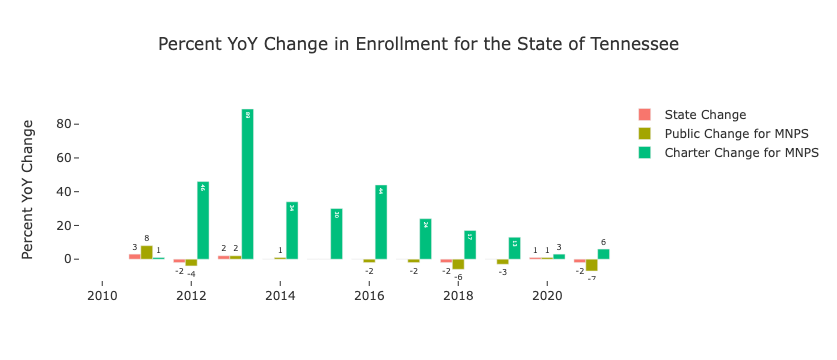

In [109]:
fig = go.Figure()

fig.add_trace(go.Bar(x=state_enrollment_over_time['file_year'], 
                     y=state_enrollment_over_time['pct_yoy_change'], 
                     name='State Change',
                     text=state_enrollment_over_time['pct_yoy_change']
                     ))


fig.add_trace(go.Bar(x=mnps_enrollment_by_school_type_over_time['file_year'], 
                     y=mnps_enrollment_by_school_type_over_time['pct_yoy_public_change'], 
                     name='Public Change for MNPS',
                     text=mnps_enrollment_by_school_type_over_time['pct_yoy_public_change']
                     )) 

fig.add_trace(go.Bar(x=mnps_enrollment_by_school_type_over_time['file_year'], 
                     y=mnps_enrollment_by_school_type_over_time['pct_yoy_charter_change'], 
                     name='Charter Change for MNPS',
                     text=mnps_enrollment_by_school_type_over_time['pct_yoy_charter_change']
                     )) 

fig.update_layout(title='Percent YoY Change in Enrollment for the State of Tennessee',
                  template='ggplot2',
                  paper_bgcolor='white', 
                  plot_bgcolor='white',)
fig.update_traces(textfont_size=8)

fig.update_yaxes(title_text="Percent YoY Change")
fig.show()

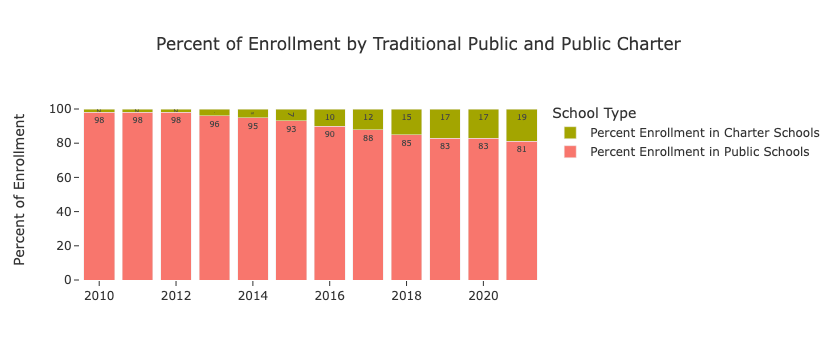

In [110]:
fig = go.Figure()

fig.add_trace(go.Bar(x=mnps_enrollment_by_school_type_over_time['file_year'], 
                     y=mnps_enrollment_by_school_type_over_time['public_enrollment_pct'], 
                     name='Percent Enrollment in Public Schools',
                     textposition='auto',
                     text=mnps_enrollment_by_school_type_over_time['public_enrollment_pct']
                     ))

fig.add_trace(go.Bar(x=mnps_enrollment_by_school_type_over_time['file_year'], 
                     y=mnps_enrollment_by_school_type_over_time['charter_enrollment_pct'], 
                     name='Percent Enrollment in Charter Schools',
                     textposition='auto',
                     text=mnps_enrollment_by_school_type_over_time['charter_enrollment_pct']
                     ))
fig.update_layout(barmode='stack',
                  legend_title_text='School Type',
                  title='Percent of Enrollment by Traditional Public and Public Charter',
                  template='ggplot2',
                  paper_bgcolor='white', 
                  plot_bgcolor='white',)
fig.update_traces(textposition='inside', textfont_size=8)
fig.update_yaxes(title_text="Percent of Enrollment")
fig.show()

## Black, Latinx, Native American

In [111]:
df_mnps_afam_ltnx_natam = df_mnps_profile.copy()
df_mnps_afam_ltnx_natam['afam_ltnx_natam_enrollment'] = df_mnps_afam_ltnx_natam['african_american_cnt'].fillna(0) + df_mnps_afam_ltnx_natam['hispanic_cnt'].fillna(0) + df_mnps_afam_ltnx_natam['native_american_cnt'].fillna(0)


afam_ltnx_natam_enrollments_by_school_type = (
    df_mnps_afam_ltnx_natam  [['file_year','school_type','afam_ltnx_natam_enrollment','total']]
    .groupby(by=['file_year','school_type'])
    .sum(['df_mnps_afam_ltnx_natam','total','african_american_cnt','hispanic_cnt','native_american_cnt'])
    .reset_index())

afam_ltnx_natam_enrollments_by_school_type['afam_ltnx_natam_share_of_pct'] = ((afam_ltnx_natam_enrollments_by_school_type['afam_ltnx_natam_enrollment'] / afam_ltnx_natam_enrollments_by_school_type.groupby(['file_year'])['afam_ltnx_natam_enrollment'].transform('sum'))*100).round(0)
afam_ltnx_natam_enrollments_by_school_type['afam_ltnx_natam_pct'] = ((afam_ltnx_natam_enrollments_by_school_type['afam_ltnx_natam_enrollment'] / afam_ltnx_natam_enrollments_by_school_type['total'])*100).round(0)

afam_ltnx_natam_enrollments_by_school_type = afam_ltnx_natam_enrollments_by_school_type.pivot(index='file_year',columns='school_type').reset_index()
afam_ltnx_natam_enrollments_by_school_type.columns = ["_".join(a) for a in afam_ltnx_natam_enrollments_by_school_type.columns.to_flat_index()]
afam_ltnx_natam_enrollments_by_school_type = afam_ltnx_natam_enrollments_by_school_type.rename(columns = {'file_year_':'file_year',
                                                                                            'afam_ltnx_natam_enrollment_Public':'afam_ltnx_natam_public_enrollment',
                                                                                            'afam_ltnx_natam_enrollment_Public Charter':'afam_ltnx_natam_charter_enrollment',
                                                                                            'total_Public':'total_public_enrollment',
                                                                                            'total_Public Charter':'total_charter_enrollment',
                                                                                           
                                                                                            'afam_ltnx_natam_share_of_pct_Public':'afam_ltnx_natam_public_share_of_pct',
                                                                                            'afam_ltnx_natam_share_of_pct_Public Charter':'afam_ltnx_natam_charter_share_of_pct',
                                                                                            'afam_ltnx_natam_pct_Public':'afam_ltnx_natam_public_pct_enrolled',
                                                                                            'afam_ltnx_natam_pct_Public Charter':'afam_ltnx_natam_charter_pct_enrolled'})

afam_ltnx_natam_enrollments_by_school_type

,file_year,afam_ltnx_natam_public_enrollment,afam_ltnx_natam_charter_enrollment,total_public_enrollment,total_charter_enrollment,afam_ltnx_natam_public_share_of_pct,afam_ltnx_natam_charter_share_of_pct,afam_ltnx_natam_public_pct_enrolled,afam_ltnx_natam_charter_pct_enrolled
0,2010,46527.0,1162.0,73893.0,1207.0,98.0,2.0,63.0,96.0
1,2011,49536.0,1158.0,79785.0,1218.0,98.0,2.0,62.0,95.0
2,2012,47189.0,1629.0,76692.0,1775.0,97.0,3.0,62.0,92.0
3,2013,48827.0,3045.0,77877.0,3360.0,94.0,6.0,63.0,91.0
4,2014,50132.0,3944.0,78788.0,4517.0,93.0,7.0,64.0,87.0
5,2015,50023.0,4976.0,78477.0,5866.0,91.0,9.0,64.0,85.0
6,2016,49272.0,6925.0,77158.0,8455.0,88.0,12.0,64.0,82.0
7,2017,48619.0,8463.0,75567.0,10462.0,85.0,15.0,64.0,81.0
8,2018,45556.0,9831.0,70695.0,12231.0,82.0,18.0,64.0,80.0
9,2019,44835.0,11052.0,68910.0,13771.0,80.0,20.0,65.0,80.0


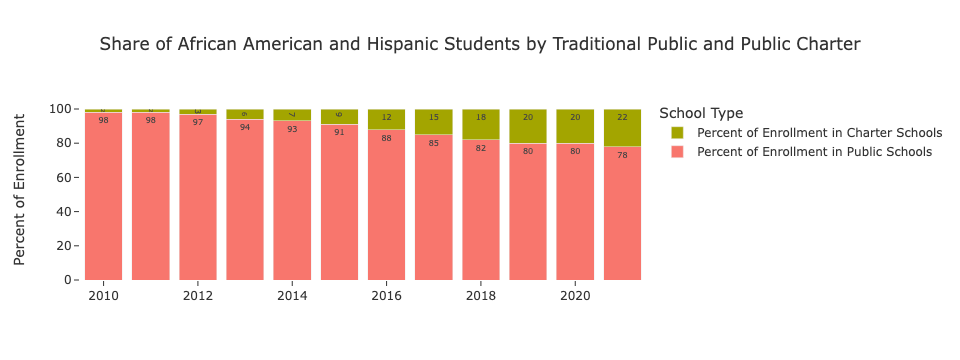

In [112]:
fig = go.Figure()

fig.add_trace(go.Bar(x=afam_ltnx_natam_enrollments_by_school_type['file_year'], 
                     y=afam_ltnx_natam_enrollments_by_school_type['afam_ltnx_natam_public_share_of_pct'], 
                     name='Percent of Enrollment in Public Schools',
                     textposition='auto',
                     text=afam_ltnx_natam_enrollments_by_school_type['afam_ltnx_natam_public_share_of_pct']
                     ))
fig.add_trace(go.Bar(x=afam_ltnx_natam_enrollments_by_school_type['file_year'], 
                     y=afam_ltnx_natam_enrollments_by_school_type['afam_ltnx_natam_charter_share_of_pct'], 
                     name='Percent of Enrollment in Charter Schools',
                     textposition='auto',
                     text=afam_ltnx_natam_enrollments_by_school_type['afam_ltnx_natam_charter_share_of_pct']
                     ))
fig.update_layout(barmode='stack',
                  legend_title_text='School Type',
                  title='Share of African American and Hispanic Students by Traditional Public and Public Charter',
                  template='ggplot2',
                  paper_bgcolor='white', 
                  plot_bgcolor='white',)
fig.update_traces(textposition='inside', textfont_size=8)
fig.update_yaxes(title_text="Percent of Enrollment")
fig.show()

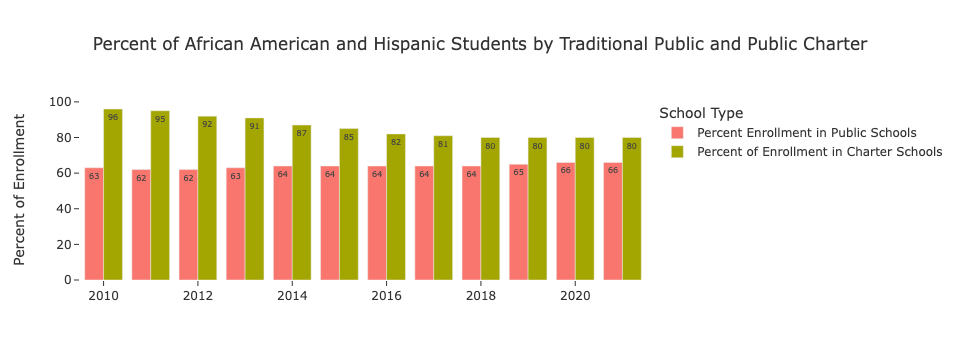

In [113]:
fig = go.Figure()

fig.add_trace(go.Bar(x=afam_ltnx_natam_enrollments_by_school_type['file_year'], 
                     y=afam_ltnx_natam_enrollments_by_school_type['afam_ltnx_natam_public_pct_enrolled'], 
                     name='Percent Enrollment in Public Schools',
                     text=afam_ltnx_natam_enrollments_by_school_type['afam_ltnx_natam_public_pct_enrolled']
                     ))
fig.add_trace(go.Bar(x=afam_ltnx_natam_enrollments_by_school_type['file_year'], 
                     y=afam_ltnx_natam_enrollments_by_school_type['afam_ltnx_natam_charter_pct_enrolled'], 
                     name='Percent of Enrollment in Charter Schools',
                     text=afam_ltnx_natam_enrollments_by_school_type['afam_ltnx_natam_charter_pct_enrolled']
                     ))
fig.update_layout(
                  legend_title_text='School Type',
                  title='Percent of African American and Hispanic Students by Traditional Public and Public Charter',
                  template='ggplot2',
                  paper_bgcolor='white', 
                  plot_bgcolor='white',)
fig.update_traces(textfont_size=8)
fig.update_yaxes(title_text="Percent of Enrollment")
fig.show()

In [114]:
afam_ltnx_natam_enrollments_by_school_type

,file_year,afam_ltnx_natam_public_enrollment,afam_ltnx_natam_charter_enrollment,total_public_enrollment,total_charter_enrollment,afam_ltnx_natam_public_share_of_pct,afam_ltnx_natam_charter_share_of_pct,afam_ltnx_natam_public_pct_enrolled,afam_ltnx_natam_charter_pct_enrolled
0,2010,46527.0,1162.0,73893.0,1207.0,98.0,2.0,63.0,96.0
1,2011,49536.0,1158.0,79785.0,1218.0,98.0,2.0,62.0,95.0
2,2012,47189.0,1629.0,76692.0,1775.0,97.0,3.0,62.0,92.0
3,2013,48827.0,3045.0,77877.0,3360.0,94.0,6.0,63.0,91.0
4,2014,50132.0,3944.0,78788.0,4517.0,93.0,7.0,64.0,87.0
5,2015,50023.0,4976.0,78477.0,5866.0,91.0,9.0,64.0,85.0
6,2016,49272.0,6925.0,77158.0,8455.0,88.0,12.0,64.0,82.0
7,2017,48619.0,8463.0,75567.0,10462.0,85.0,15.0,64.0,81.0
8,2018,45556.0,9831.0,70695.0,12231.0,82.0,18.0,64.0,80.0
9,2019,44835.0,11052.0,68910.0,13771.0,80.0,20.0,65.0,80.0


## Economically Disadvantaged

In [115]:
df_mnps_econ_disadv = df_mnps_profile.copy()


econ_disadv_enrollments_by_school_type = (
    df_mnps_econ_disadv[['file_year','school_type','economically_disadvantaged_cnt','total']]
    .groupby(by=['file_year','school_type'])
    .sum(['economically_disadvantaged_cnt','total'])
    .reset_index())

econ_disadv_enrollments_by_school_type['econ_disadv_share_of_pct'] = ((econ_disadv_enrollments_by_school_type['economically_disadvantaged_cnt'] / econ_disadv_enrollments_by_school_type.groupby(['file_year'])['economically_disadvantaged_cnt'].transform('sum'))*100).round(0)
econ_disadv_enrollments_by_school_type['econ_disadv_pct'] = ((econ_disadv_enrollments_by_school_type['economically_disadvantaged_cnt'] / econ_disadv_enrollments_by_school_type['total'])*100).round(0)

econ_disadv_enrollments_by_school_type = econ_disadv_enrollments_by_school_type.pivot(index='file_year',columns='school_type').reset_index()
econ_disadv_enrollments_by_school_type.columns = ["_".join(a) for a in econ_disadv_enrollments_by_school_type.columns.to_flat_index()]
econ_disadv_enrollments_by_school_type = econ_disadv_enrollments_by_school_type.rename(columns = {'file_year_':'file_year',
                                                                                            'economically_disadvantaged_cnt_Public':'econ_disadv_public_enrollment',
                                                                                            'economically_disadvantaged_cnt_Public Charter':'econ_disadv_charter_enrollment',
                                                                                            'total_Public':'total_public_enrollment',
                                                                                            'total_Public Charter':'total_charter_enrollment',
                                                                                           
                                                                                            'econ_disadv_share_of_pct_Public':'econ_disadv_public_share_of_pct',
                                                                                            'econ_disadv_share_of_pct_Public Charter':'econ_disadv_charter_share_of_pct',
                                                                                            'econ_disadv_pct_Public':'econ_disadv_public_pct_enrolled',
                                                                                            'econ_disadv_pct_Public Charter':'econ_disadv_charter_pct_enrolled'})

econ_disadv_enrollments_by_school_type

,file_year,econ_disadv_public_enrollment,econ_disadv_charter_enrollment,total_public_enrollment,total_charter_enrollment,econ_disadv_public_share_of_pct,econ_disadv_charter_share_of_pct,econ_disadv_public_pct_enrolled,econ_disadv_charter_pct_enrolled
0,2010,51904.0,1121.0,73893.0,1207.0,98.0,2.0,70.0,93.0
1,2011,58392.0,872.0,79785.0,1218.0,99.0,1.0,73.0,72.0
2,2012,54385.0,1462.0,76692.0,1775.0,97.0,3.0,71.0,82.0
3,2013,56083.0,3048.0,77877.0,3360.0,95.0,5.0,72.0,91.0
4,2014,56925.0,3930.0,78788.0,4517.0,94.0,6.0,72.0,87.0
5,2015,58574.0,4765.0,78477.0,5866.0,92.0,8.0,75.0,81.0
6,2016,40953.0,5469.0,77158.0,8455.0,88.0,12.0,53.0,65.0
7,2017,37758.0,6097.0,75567.0,10462.0,86.0,14.0,50.0,58.0
8,2018,32537.0,6469.0,70695.0,12231.0,83.0,17.0,46.0,53.0
9,2019,29804.0,6859.0,68910.0,13771.0,81.0,19.0,43.0,50.0


In [116]:
df_state_econ_disadv = df_state_profile.copy()


econ_disadv_enrollments_by_state = (
    df_state_econ_disadv[['file_year','school_type','economically_disadvantaged_cnt','total']]
    .groupby(by=['file_year'])
    .sum(['economically_disadvantaged_cnt','total'])
    .reset_index())

econ_disadv_enrollments_by_state['econ_disadv_pct'] = ((econ_disadv_enrollments_by_state['economically_disadvantaged_cnt'] / econ_disadv_enrollments_by_state['total'])*100).round(0)


econ_disadv_enrollments_by_state

,file_year,economically_disadvantaged_cnt,total,econ_disadv_pct
0,2010,5509.0,972153.0,1.0
1,2011,5630.0,998223.0,1.0
2,2012,5700.0,976855.0,1.0
3,2013,582217.0,993256.0,59.0
4,2014,584099.0,993841.0,59.0
5,2015,576636.0,995892.0,58.0
6,2016,350260.0,997893.0,35.0
7,2017,346896.0,999701.0,35.0
8,2018,352055.0,975222.0,36.0
9,2019,339807.0,973659.0,35.0


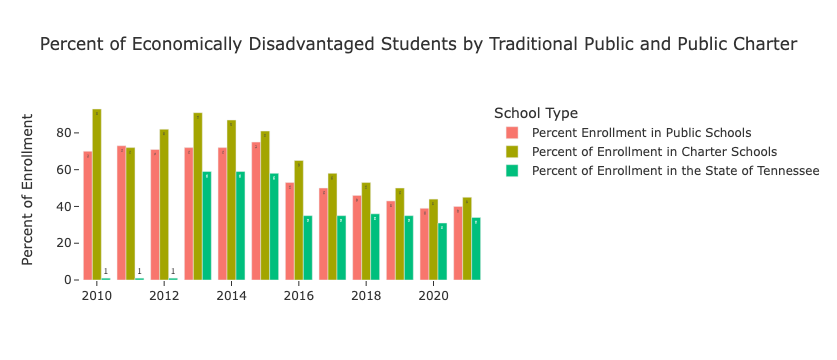

In [117]:
fig = go.Figure()

fig.add_trace(go.Bar(x=econ_disadv_enrollments_by_school_type['file_year'], 
                     y=econ_disadv_enrollments_by_school_type['econ_disadv_public_pct_enrolled'], 
                     name='Percent Enrollment in Public Schools',
                     text=econ_disadv_enrollments_by_school_type['econ_disadv_public_pct_enrolled']
                     ))
fig.add_trace(go.Bar(x=econ_disadv_enrollments_by_school_type['file_year'], 
                     y=econ_disadv_enrollments_by_school_type['econ_disadv_charter_pct_enrolled'], 
                     name='Percent of Enrollment in Charter Schools',
                     text=econ_disadv_enrollments_by_school_type['econ_disadv_charter_pct_enrolled']
                     ))
fig.add_trace(go.Bar(x=econ_disadv_enrollments_by_state['file_year'], 
                     y=econ_disadv_enrollments_by_state['econ_disadv_pct'], 
                     name='Percent of Enrollment in the State of Tennessee',
                     text=econ_disadv_enrollments_by_state['econ_disadv_pct']
                     ))
fig.update_layout(
                  legend_title_text='School Type',
                  title='Percent of Economically Disadvantaged Students by Traditional Public and Public Charter',
                  template='ggplot2',
                  paper_bgcolor='white', 
                  plot_bgcolor='white',)
fig.update_traces(textfont_size=8)
fig.update_yaxes(title_text="Percent of Enrollment")
fig.show()

Definition of Economically Disadvantaged changed in 2016. See page 7-8 in this report: https://www.tn.gov/content/dam/tn/education/documents/Annual_Charter_Report_for_SY_2018-19_FINAL.pdf.

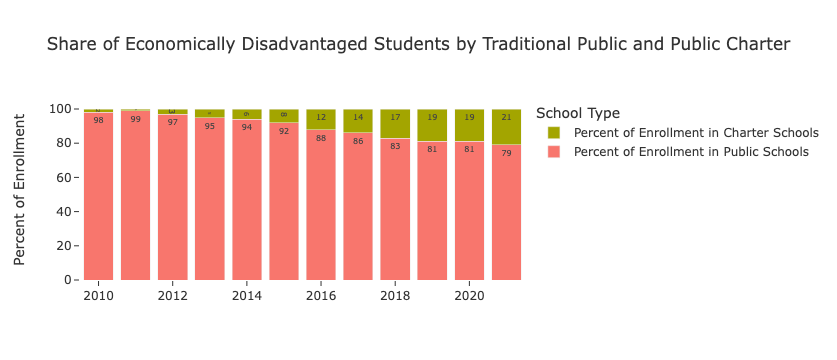

In [118]:
fig = go.Figure()

fig.add_trace(go.Bar(x=econ_disadv_enrollments_by_school_type['file_year'], 
                     y=econ_disadv_enrollments_by_school_type['econ_disadv_public_share_of_pct'], 
                     name='Percent of Enrollment in Public Schools',
                     textposition='auto',
                     text=econ_disadv_enrollments_by_school_type['econ_disadv_public_share_of_pct']
                     ))
fig.add_trace(go.Bar(x=econ_disadv_enrollments_by_school_type['file_year'], 
                     y=econ_disadv_enrollments_by_school_type['econ_disadv_charter_share_of_pct'], 
                     name='Percent of Enrollment in Charter Schools',
                     textposition='auto',
                     text=econ_disadv_enrollments_by_school_type['econ_disadv_charter_share_of_pct']
                     ))
fig.update_layout(barmode='stack',
                  legend_title_text='School Type',
                  title='Share of Economically Disadvantaged Students by Traditional Public and Public Charter',
                  template='ggplot2',
                  paper_bgcolor='white', 
                  plot_bgcolor='white',)
fig.update_traces(textposition='inside', textfont_size=8)
fig.update_yaxes(title_text="Percent of Enrollment")
fig.show()

In [119]:
econ_disadv_enrollments_by_school_type

,file_year,econ_disadv_public_enrollment,econ_disadv_charter_enrollment,total_public_enrollment,total_charter_enrollment,econ_disadv_public_share_of_pct,econ_disadv_charter_share_of_pct,econ_disadv_public_pct_enrolled,econ_disadv_charter_pct_enrolled
0,2010,51904.0,1121.0,73893.0,1207.0,98.0,2.0,70.0,93.0
1,2011,58392.0,872.0,79785.0,1218.0,99.0,1.0,73.0,72.0
2,2012,54385.0,1462.0,76692.0,1775.0,97.0,3.0,71.0,82.0
3,2013,56083.0,3048.0,77877.0,3360.0,95.0,5.0,72.0,91.0
4,2014,56925.0,3930.0,78788.0,4517.0,94.0,6.0,72.0,87.0
5,2015,58574.0,4765.0,78477.0,5866.0,92.0,8.0,75.0,81.0
6,2016,40953.0,5469.0,77158.0,8455.0,88.0,12.0,53.0,65.0
7,2017,37758.0,6097.0,75567.0,10462.0,86.0,14.0,50.0,58.0
8,2018,32537.0,6469.0,70695.0,12231.0,83.0,17.0,46.0,53.0
9,2019,29804.0,6859.0,68910.0,13771.0,81.0,19.0,43.0,50.0


## Students With Disabilities

In [120]:
df_mnps_swd = df_mnps_profile.copy()

swd_enrollments_by_school_type = (
    df_mnps_swd[['file_year','school_type','students_with_disabilities_cnt','total']]
    .groupby(by=['file_year','school_type'])
    .sum(['students_with_disabilities_cnt','total'])
    .reset_index())

swd_enrollments_by_school_type['swd_share_of_pct'] = ((swd_enrollments_by_school_type['students_with_disabilities_cnt'] / swd_enrollments_by_school_type.groupby(['file_year'])['students_with_disabilities_cnt'].transform('sum'))*100).round(0)
swd_enrollments_by_school_type['swd_pct'] = ((swd_enrollments_by_school_type['students_with_disabilities_cnt'] / swd_enrollments_by_school_type['total'])*100).round(0)

swd_enrollments_by_school_type = swd_enrollments_by_school_type.pivot(index='file_year',columns='school_type').reset_index()
swd_enrollments_by_school_type.columns = ["_".join(a) for a in swd_enrollments_by_school_type.columns.to_flat_index()]
swd_enrollments_by_school_type = swd_enrollments_by_school_type.rename(columns = {'file_year_':'file_year',
                                                                                            'students_with_disabilities_cnt_Public':'swd_public_enrollment',
                                                                                            'students_with_disabilities_cnt_Public Charter':'swd_charter_enrollment',
                                                                                            'total_Public':'total_public_enrollment',
                                                                                            'total_Public Charter':'total_charter_enrollment',
                                                                                           
                                                                                            'swd_share_of_pct_Public':'swd_public_share_of_pct',
                                                                                            'swd_share_of_pct_Public Charter':'swd_charter_share_of_pct',
                                                                                            'swd_pct_Public':'swd_public_pct_enrolled',
                                                                                            'swd_pct_Public Charter':'swd_charter_pct_enrolled'})

swd_enrollments_by_school_type

,file_year,swd_public_enrollment,swd_charter_enrollment,total_public_enrollment,total_charter_enrollment,swd_public_share_of_pct,swd_charter_share_of_pct,swd_public_pct_enrolled,swd_charter_pct_enrolled
0,2010,0.0,0.0,73893.0,1207.0,NaN,NaN,0.0,0.0
1,2011,0.0,0.0,79785.0,1218.0,NaN,NaN,0.0,0.0
2,2012,0.0,0.0,76692.0,1775.0,NaN,NaN,0.0,0.0
3,2013,9331.0,432.0,77877.0,3360.0,96.0,4.0,12.0,13.0
4,2014,9790.0,591.0,78788.0,4517.0,94.0,6.0,12.0,13.0
5,2015,9848.0,677.0,78477.0,5866.0,94.0,6.0,13.0,12.0
6,2016,10028.0,951.0,77158.0,8455.0,91.0,9.0,13.0,11.0
7,2017,10078.0,1178.0,75567.0,10462.0,90.0,10.0,13.0,11.0
8,2018,9491.0,1465.0,70695.0,12231.0,87.0,13.0,13.0,12.0
9,2019,9035.0,1670.0,68910.0,13771.0,84.0,16.0,13.0,12.0


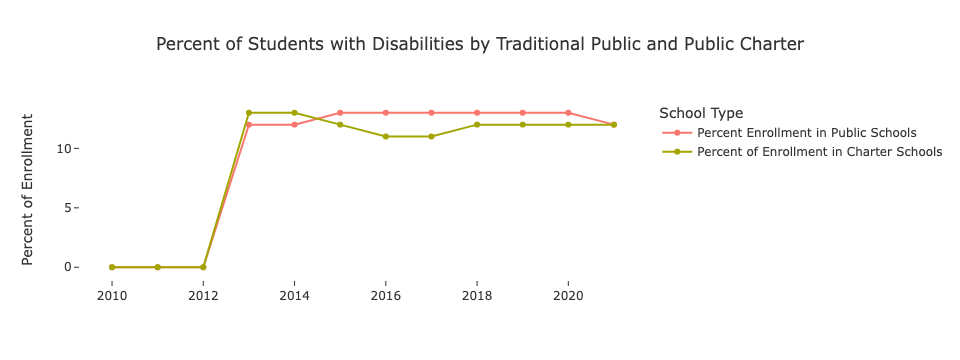

In [121]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=swd_enrollments_by_school_type['file_year'], 
                     y=swd_enrollments_by_school_type['swd_public_pct_enrolled'], 
                     name='Percent Enrollment in Public Schools',
                     text=swd_enrollments_by_school_type['swd_public_pct_enrolled']
                     ))
fig.add_trace(go.Scatter(x=swd_enrollments_by_school_type['file_year'], 
                     y=swd_enrollments_by_school_type['swd_charter_pct_enrolled'], 
                     name='Percent of Enrollment in Charter Schools',
                     text=swd_enrollments_by_school_type['swd_charter_pct_enrolled']
                     ))
fig.update_layout(
                  legend_title_text='School Type',
                  title='Percent of Students with Disabilities by Traditional Public and Public Charter',
                  template='ggplot2',
                  paper_bgcolor='white', 
                  plot_bgcolor='white',)
fig.update_traces(textfont_size=8)
fig.update_yaxes(title_text="Percent of Enrollment")
fig.show()

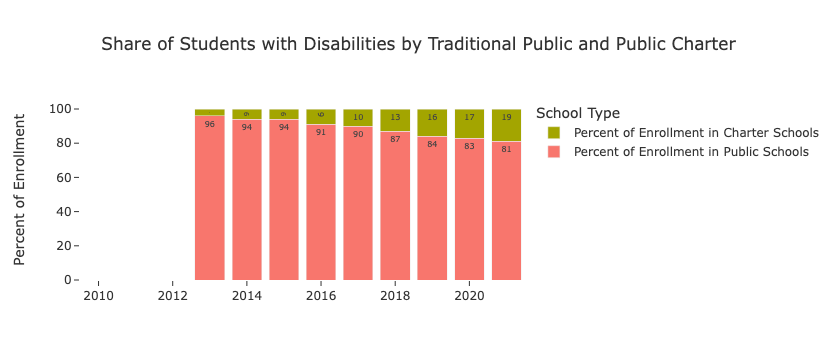

In [122]:
fig = go.Figure()

fig.add_trace(go.Bar(x=swd_enrollments_by_school_type['file_year'], 
                     y=swd_enrollments_by_school_type['swd_public_share_of_pct'], 
                     name='Percent of Enrollment in Public Schools',
                     textposition='auto',
                     text=swd_enrollments_by_school_type['swd_public_share_of_pct']
                     ))
fig.add_trace(go.Bar(x=swd_enrollments_by_school_type['file_year'], 
                     y=swd_enrollments_by_school_type['swd_charter_share_of_pct'], 
                     name='Percent of Enrollment in Charter Schools',
                     textposition='auto',
                     text=swd_enrollments_by_school_type['swd_charter_share_of_pct']
                     ))
fig.update_layout(barmode='stack',
                  legend_title_text='School Type',
                  title='Share of Students with Disabilities by Traditional Public and Public Charter',
                  template='ggplot2',
                  paper_bgcolor='white', 
                  plot_bgcolor='white',)
fig.update_traces(textposition='inside', textfont_size=8)
fig.update_yaxes(title_text="Percent of Enrollment")
fig.show()

## English Learner

In [123]:
df_mnps_el = df_mnps_profile.copy()

el_enrollments_by_school_type = (
    df_mnps_el[['file_year','school_type','limited_english_proficient_cnt','total']]
    .groupby(by=['file_year','school_type'])
    .sum(['limited_english_proficient_cnt','total'])
    .reset_index())

el_enrollments_by_school_type['el_share_of_pct'] = ((el_enrollments_by_school_type['limited_english_proficient_cnt'] / el_enrollments_by_school_type.groupby(['file_year'])['limited_english_proficient_cnt'].transform('sum'))*100).round(0)
el_enrollments_by_school_type['el_pct'] = ((el_enrollments_by_school_type['limited_english_proficient_cnt'] / el_enrollments_by_school_type['total'])*100).round(0)

el_enrollments_by_school_type = el_enrollments_by_school_type.pivot(index='file_year',columns='school_type').reset_index()
el_enrollments_by_school_type.columns = ["_".join(a) for a in el_enrollments_by_school_type.columns.to_flat_index()]
el_enrollments_by_school_type = el_enrollments_by_school_type.rename(columns = {'file_year_':'file_year',
                                                                                            'limited_english_proficient_cnt_Public':'swd_public_enrollment',
                                                                                            'limited_english_proficient_cnt_Public Charter':'swd_charter_enrollment',
                                                                                            'total_Public':'total_public_enrollment',
                                                                                            'total_Public Charter':'total_charter_enrollment',
                                                                                           
                                                                                            'el_share_of_pct_Public':'el_public_share_of_pct',
                                                                                            'el_share_of_pct_Public Charter':'el_charter_share_of_pct',
                                                                                            'el_pct_Public':'el_public_pct_enrolled',
                                                                                            'el_pct_Public Charter':'el_charter_pct_enrolled'})

el_enrollments_by_school_type

,file_year,swd_public_enrollment,swd_charter_enrollment,total_public_enrollment,total_charter_enrollment,el_public_share_of_pct,el_charter_share_of_pct,el_public_pct_enrolled,el_charter_pct_enrolled
0,2010,0.0,0.0,73893.0,1207.0,NaN,NaN,0.0,0.0
1,2011,0.0,0.0,79785.0,1218.0,NaN,NaN,0.0,0.0
2,2012,0.0,0.0,76692.0,1775.0,NaN,NaN,0.0,0.0
3,2013,11479.0,276.0,77877.0,3360.0,98.0,2.0,15.0,8.0
4,2014,12199.0,512.0,78788.0,4517.0,96.0,4.0,15.0,11.0
5,2015,12798.0,865.0,78477.0,5866.0,94.0,6.0,16.0,15.0
6,2016,13512.0,1529.0,77158.0,8455.0,90.0,10.0,18.0,18.0
7,2017,14142.0,2118.0,75567.0,10462.0,87.0,13.0,19.0,20.0
8,2018,12028.0,1830.0,70695.0,12231.0,87.0,13.0,17.0,15.0
9,2019,11833.0,2038.0,68910.0,13771.0,85.0,15.0,17.0,15.0


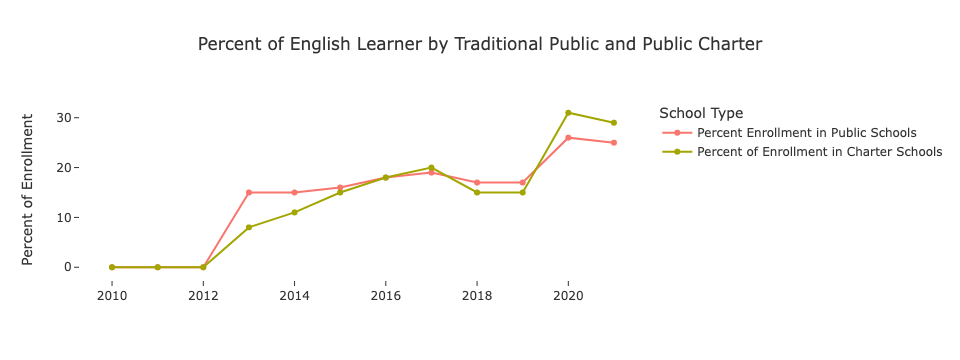

In [124]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=el_enrollments_by_school_type['file_year'], 
                     y=el_enrollments_by_school_type['el_public_pct_enrolled'], 
                     name='Percent Enrollment in Public Schools',
                     text=el_enrollments_by_school_type['el_public_pct_enrolled']
                     ))
fig.add_trace(go.Scatter(x=el_enrollments_by_school_type['file_year'], 
                     y=el_enrollments_by_school_type['el_charter_pct_enrolled'], 
                     name='Percent of Enrollment in Charter Schools',
                     text=el_enrollments_by_school_type['el_charter_pct_enrolled']
                     ))
fig.update_layout(
                  legend_title_text='School Type',
                  title='Percent of English Learner by Traditional Public and Public Charter',
                  template='ggplot2',
                  paper_bgcolor='white', 
                  plot_bgcolor='white',)
fig.update_traces(textfont_size=8)
fig.update_yaxes(title_text="Percent of Enrollment")
fig.show()

In [125]:
with pd.ExcelWriter('../data_for_analysis/enrollment.xlsx') as writer:  
    pd.concat([state_enrollment_over_time,mnps_enrollment_by_school_type_over_time], axis=1).to_excel(writer, sheet_name='enrollment')
    swd_enrollments_by_school_type.to_excel(writer, sheet_name='swd')
    el_enrollments_by_school_type.to_excel(writer, sheet_name='el')
    econ_disadv_enrollments_by_school_type.to_excel(writer, sheet_name='econ_disadv')
    afam_ltnx_natam_enrollments_by_school_type.to_excel(writer, sheet_name='black_latinx_natam')